<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-4--job-resume-improvement/01_measuring_text_similarities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Measuring text similarities

In this notebook, we focus on a basic NLP problem: **measuring the similarity between two texts**. 

We will quickly discover a feasible solution that is not computationally efficient.
We will then explore a series of numerical techniques for rapidly computing
text similarities.

##Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import defaultdict
from collections import Counter
import numpy as np
import pandas as pd

from scipy.spatial.distance import euclidean
from numpy.linalg import norm

import seaborn as sns
import matplotlib.pyplot as plt

##Simple text comparison

Suppose we want to compare three simple texts:

```text
text1—She sells seashells by the seashore
text2—“Seashells! The seashells are on sale! By the seashore.”
text3—She sells 3 seashells to John, who lives by the lake.
```

Our goal is to determine whether `text1` is more similar to `text2` or to `text3`.



In [3]:
# Assigning texts to variables
text1 = "She sells seashells by the seashore."
text2 = '"Seashells! The seashells are on sale! By the seashore."'
text3 = "She sells 3 seashells to John, who lives by the lake."

Now we need to quantify the differences between texts.

In [4]:
# Splitting texts into words
words_lists = [text.split() for text in [text1, text2, text3]]
words1, words2, words3 = words_lists

for i, words in enumerate(words_lists, 1):
  print(f"Words in text {i}")
  print(f"{words}\n")

Words in text 1
['She', 'sells', 'seashells', 'by', 'the', 'seashore.']

Words in text 2
['"Seashells!', 'The', 'seashells', 'are', 'on', 'sale!', 'By', 'the', 'seashore."']

Words in text 3
['She', 'sells', '3', 'seashells', 'to', 'John,', 'who', 'lives', 'by', 'the', 'lake.']



In [5]:
# Removing case sensitivity and punctuation
def simplify_text(text):
  for punctuation in ['.', ',', '!', '?', '"']:
    text = text.replace(punctuation, "")
  return text.lower()

In [6]:
for i, words in enumerate(words_lists, 1):
  for j, word in enumerate(words):
    words[j] = simplify_text(word)
  print(f"Words in text {i}")
  print(f"{words}\n")

Words in text 1
['she', 'sells', 'seashells', 'by', 'the', 'seashore']

Words in text 2
['seashells', 'the', 'seashells', 'are', 'on', 'sale', 'by', 'the', 'seashore']

Words in text 3
['she', 'sells', '3', 'seashells', 'to', 'john', 'who', 'lives', 'by', 'the', 'lake']



In [7]:
# Converting word lists to sets
words_sets = [set(words) for words in words_lists]
for i, unique_words in enumerate(words_sets, 1):
  print(f"Unique Words in text {i}")
  print(f"{unique_words}\n")

Unique Words in text 1
{'sells', 'seashore', 'seashells', 'she', 'by', 'the'}

Unique Words in text 2
{'sale', 'seashore', 'are', 'seashells', 'on', 'by', 'the'}

Unique Words in text 3
{'sells', 'seashells', 'lake', '3', 'john', 'who', 'lives', 'to', 'she', 'by', 'the'}



In [8]:
# Extracting overlapping words between two texts
words_set1 = words_sets[0]
for i, words_set in enumerate(words_sets[1:], 2):
  shared_words = words_set1 & words_set
  print(f"Texts 1 and {i} share these {len(shared_words)} words:")
  print(f"{shared_words}\n")

Texts 1 and 2 share these 4 words:
{'seashells', 'the', 'by', 'seashore'}

Texts 1 and 3 share these 5 words:
{'sells', 'seashells', 'she', 'by', 'the'}



In [9]:
# Extracting diverging words between two texts
for i, words_set in enumerate(words_sets[1:], 2):
  diverging_words = words_set1 ^ words_set
  print(f"Texts 1 and {i} don't share these {len(diverging_words)} words:")
  print(f"{diverging_words}\n")

Texts 1 and 2 don't share these 5 words:
{'sale', 'sells', 'are', 'on', 'she'}

Texts 1 and 3 don't share these 7 words:
{'seashore', 'lake', '3', 'john', 'who', 'lives', 'to'}



To combine their overlap and divergence into a single similarity score, we must first combine all overlapping
and diverging words between the texts. 

This aggregation, which is called a union, will
contain all the unique words across the two texts.

In [10]:
# Extracting the union of words between two texts
for i, words_set in enumerate(words_sets[1:], 2):
  total_words = words_set1 | words_set
  print(f"Together, texts 1 and {i} contain {len(total_words)} unique words. These words are:\n {total_words}\n")

Together, texts 1 and 2 contain 9 unique words. These words are:
 {'sale', 'sells', 'seashore', 'are', 'seashells', 'on', 'she', 'by', 'the'}

Together, texts 1 and 3 contain 12 unique words. These words are:
 {'seashore', 'lives', 'by', 'the', 'sells', 'seashells', '3', 'john', 'who', 'to', 'she', 'lake'}



Accordingly, both overlap and divergence represent complementary
percentages of the total unique word count across texts.

In [11]:
# Extracting the percentage of shared words between two texts
for i, words_set in enumerate(words_sets[1:], 2):
  shared_words = words_set1 & words_set
  diverging_words = words_set1 ^ words_set
  total_words = words_set1 | words_set
  assert len(total_words) == len(shared_words) + len(diverging_words)

  # Percent of total words shared with text 1
  percent_shared = 100 * len(shared_words) / len(total_words)
  # Percent of total words that diverge from text 1 
  percent_diverging = 100 * len(diverging_words) / len(total_words)

  print(f"Together, texts 1 and {i} contain {len(total_words)} unique words. \n{percent_shared:.2f}% of these words are shared.\n{percent_diverging:.2f}% of these words diverge.\n")

Together, texts 1 and 2 contain 9 unique words. 
44.44% of these words are shared.
55.56% of these words diverge.

Together, texts 1 and 3 contain 12 unique words. 
41.67% of these words are shared.
58.33% of these words diverge.



We’ve essentially developed a simple metric for assessing similarities between texts.

This similarity metric is referred to as the Jaccard similarity, or the Jaccard index.

###Exploring the Jaccard similarity

The Jaccard similarity is a reasonable measure of text resemblance for the following reasons:

* The similarity takes into account both text overlap and text divergence.
* The fractional similarity is always between 0 and 1. The fraction is easy to interpret: 0 indicates that no words are shared, 0.5 indicates that half the words are shared, and 1 indicates that all the words are shared.
* The similarity is simple to implement.

In [12]:
# Computing the Jaccard similarity
def jaccard_similarity(text_a, text_b):
  word_set_a, word_set_b = [set(simplify_text(text).split()) for text in [text_a, text_b]]
  num_shared = len(word_set_a & word_set_b)
  num_total = len(word_set_a | word_set_b)
  return num_shared / num_total

In [13]:
for text in [text2, text3]:
  similarity = jaccard_similarity(text1, text)
  print(f"Text comparison:\n\t{text1}\n\t{text}\nThe Jaccard similarity is {similarity:.2f}\n")

Text comparison:
	She sells seashells by the seashore.
	"Seashells! The seashells are on sale! By the seashore."
The Jaccard similarity is 0.44

Text comparison:
	She sells seashells by the seashore.
	She sells 3 seashells to John, who lives by the lake.
The Jaccard similarity is 0.42



In [14]:
# Efficiently computing the Jaccard similarity
def jaccard_similarity_efficient(text_a, text_b):
  word_set_a, word_set_b = [set(simplify_text(text).split()) for text in [text_a, text_b]]
  num_shared = len(word_set_a & word_set_b)
  num_total = len(word_set_a) + len(word_set_b) - num_shared
  return num_shared / num_total

In [15]:
for text in [text2, text3]:
  similarity = jaccard_similarity_efficient(text1, text)
  assert similarity == jaccard_similarity(text1, text)
  print(f"Text comparison:\n\t{text1}\n\t{text}\nThe Jaccard similarity is {similarity:.2f}\n")

Text comparison:
	She sells seashells by the seashore.
	"Seashells! The seashells are on sale! By the seashore."
The Jaccard similarity is 0.44

Text comparison:
	She sells seashells by the seashore.
	She sells 3 seashells to John, who lives by the lake.
The Jaccard similarity is 0.42



###Replacing words with numeric values

The mapping between words
and their numeric values can be stored in a Python dictionary. We’ll refer to this dictionary
as our vocabulary. 

Let’s build a vocabulary that covers all the words in our three
texts.

In [16]:
# Assigning words to numbers in a vocabulary
words_set1, words_set2, words_set3 = words_sets
total_words = words_set1 | words_set2 | words_set3
vocabulary = {word: i for i, word in enumerate(total_words)}
value_to_word = {value: word for word, value in vocabulary.items()}
print(f"Our vocabulary contains {len(vocabulary)} words. This vocabulary is:\n{vocabulary}")

Our vocabulary contains 15 words. This vocabulary is:
{'sale': 0, 'seashore': 1, 'are': 2, 'lives': 3, 'on': 4, 'by': 5, 'the': 6, 'sells': 7, 'seashells': 8, '3': 9, 'john': 10, 'who': 11, 'to': 12, 'she': 13, 'lake': 14}


Given our vocabulary, we can convert any text into a one-dimensional array of numbers.

Mathematically, a 1D numeric array is called a vector. 

Hence, the process of converting
text into a vector is called text vectorization.

Let’s use binary vectorization to convert all texts into NumPy arrays.

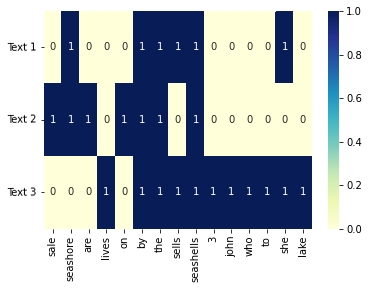

In [17]:
# Transforming words into binary vectors
vectors = []
for i, words_set in enumerate(words_sets, 1):
  # Generates an array of 0s
  vector = np.array([0] * len(vocabulary))
  for word in words_set:
    vector[vocabulary[word]] = 1
  vectors.append(vector)

sns.heatmap(vectors, annot=True, cmap="YlGnBu", 
             xticklabels=vocabulary.keys(),
             yticklabels=["Text 1", "Text 2", "Text 3"])
plt.yticks(rotation=1)
plt.show()

Our binary vector representation allows us to extract shared words numerically.

In [18]:
# Finding shared words using vector arithmetic
vector1, vector2 = vectors[:2]
for i in range(len(vocabulary)):
  if vector1[i] * vector2[i]:
    shared_word = value_to_word[i]
    print(f"'{shared_word}' is present in both texts 1 and 2")

'seashore' is present in both texts 1 and 2
'by' is present in both texts 1 and 2
'the' is present in both texts 1 and 2
'seashells' is present in both texts 1 and 2


In [19]:
# Counting shared words using vector arithmetic
shared_word_count = sum(vector1[i] * vector2[i] for i in range(len(vocabulary)))
assert shared_word_count == len(words_set1 & words_set2)

The sum of the pairwise products across all vector indices is called the dot product.

In [20]:
# Computing a vector dot product using NumPy
assert vector1.dot(vector2) == shared_word_count
assert vector1 @ vector2 == shared_word_count

Stated more concisely, `vector1 @ vector1` should equal the number of unique words
in `text1`, which is also equal to `len(words_set1)`. 

Let’s confirm.

In [21]:
assert vector1 @ vector1 == len(words_set1)
assert vector2 @ vector2 == len(words_set2)

Essentially, we can compute the Jaccard similarity using only
vector operations. 

This vectorized implementation of Jaccard is called the Tanimoto
similarity.

In [22]:
# Computing text similarity using vector arithmetic
def tanimoto_similarity(vector_a, vector_b):
  num_shared = vector_a @ vector_b
  num_total = vector_a @ vector_a + vector_b @ vector_b - num_shared
  return num_shared / num_total

In [23]:
for i, text in enumerate([text2, text3], 1):
  similarity = tanimoto_similarity(vector1, vectors[i])
  assert similarity == jaccard_similarity(text1, text)

What
would happen if we inputted two arrays with values other than 0 or 1? 

Technically,
the function should return a similarity, but would that similarity make sense? 

For
instance, vectors `[5, 3]` and `[5, 2]` are nearly identical. We expect their similarity to be nearly equal to 1.

Let’s test our expectations by inputting the vectors.

In [24]:
# Computing the similarity of non-binary vectors
non_binary_vector1 = np.array([5, 3])
non_binary_vector2 = np.array([5, 2])

similarity = tanimoto_similarity(non_binary_vector1, non_binary_vector2)
print(f"The similarity of 2 non-binary vectors is {similarity}")

The similarity of 2 non-binary vectors is 0.96875


The outputted value is nearly equal to 1. 

Thus, `tanimoto_similarity` has successfully
measured the similarity between two nearly identical vectors. The function can analyze
non-binary inputs. 

This means we can use non-binary techniques to vectorize our
texts before comparing their contents.

##Vectorizing texts using word counts

Binary vectorization captures the presence and absence of words in a text, but it
doesn’t capture word counts. This is unfortunate since word counts can provide a differentiating
signal between texts.

A vector of word counts is
commonly referred to as a term-frequency vector, or a TF vector for short.

Let’s compute
the TF vectors of A and B using a two-element vocabulary `{'duck': 0, 'goose': 1}`.

In [25]:
# Computing TF vector similarity
similarity = tanimoto_similarity(np.array([61, 2]), np.array([1, 71]))
print(f"The similarity between texts is approximately {similarity:.3f}")

The similarity between texts is approximately 0.024


Let’s compare it to the binaryvector
similarity of the two texts.

In [26]:
# Assessing identical vector similarity
assert tanimoto_similarity(np.array([1, 1]), np.array([1, 1])) == 1

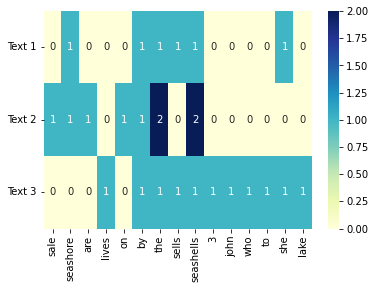

In [27]:
# Computing TF vectors from word lists
tf_vectors = []
for i, words_list in enumerate(words_lists, 1):
  tf_vector = np.array([0] * len(vocabulary))
  for word in words_list:
    word_index = vocabulary[word]
    tf_vector[word_index] += 1
  tf_vectors.append(tf_vector)

sns.heatmap(tf_vectors, cmap="YlGnBu", annot=True, xticklabels=vocabulary.keys(), yticklabels=["Text 1", "Text 2", "Text 3"])
plt.yticks(rotation=0)
plt.show()

In [28]:
# Comparing metrics of vector similarity
tf_vector1 = tf_vectors[0]
binary_vector1 = vectors[0]

for i, tf_vector in enumerate(tf_vectors[1:], 2):
  similarity = tanimoto_similarity(tf_vector1, tf_vector)
  old_similarity = tanimoto_similarity(tf_vector1, vectors[i - 1])
  print(f"The recomputed Tanimoto similarity between texts 1 and {i} is {similarity:.3f}")
  print(f"Previously, that similarity equaled {old_similarity:.3f} \n")

The recomputed Tanimoto similarity between texts 1 and 2 is 0.462
Previously, that similarity equaled 0.444 

The recomputed Tanimoto similarity between texts 1 and 3 is 0.417
Previously, that similarity equaled 0.417 



TF vectors yield improved comparisons because they’re sensitive to count differences
between texts. This sensitivity is useful. However, it can also be detrimental
when comparing texts of different lengths.

### TF vector similarity using normalization

Suppose you run a query for “Pepperoni Pizza” and the following two titles are
returned:

* **Title A**—“Pepperoni Pizza! Pepperoni Pizza! Pepperoni Pizza!”
* **Title B**—“Pepperoni”

Which of our two titles best matches the query? Most data scientists would agree that
title A is a better match than title B. 

Both title A and the query mention pepperoni pizza.
Meanwhile, title B mentions only pepperoni. There is no indication that the associated
document actually discusses pizza in any context.

Let’s check whether title A ranks higher than title B relative to the query.

In [29]:
# Simple search engine vectorization
query_vector = np.array([1, 1])
title_a_vector = np.array([3, 3])
title_b_vector = np.array([1, 0])

In [30]:
# Ranking titles by query similarity
titles = [
  "A: Pepperoni Pizza! Pepperoni Pizza! Pepperoni Pizza!",
  "B: Pepperoni"        
]

title_vectors = [title_a_vector, title_b_vector]
similarities = [tanimoto_similarity(query_vector, title_vector) for title_vector in title_vectors]

for index in sorted(range(len(titles)), key= lambda i: similarities[i], reverse=True):
  title = titles[index]
  similarity = similarities[index]
  print(f"{title} has a query similarity of {similarity:.4f}")

B: Pepperoni has a query similarity of 0.5000
A: Pepperoni Pizza! Pepperoni Pizza! Pepperoni Pizza! has a query similarity of 0.4286


Unfortunately, title A outranks title B. This discrepancy in rankings is caused by text
size. 

Title A has three times as many words as the query, while title B and the query differ
by just a single word.

In [31]:
# Eliminating size differences through division
assert np.array_equal(query_vector, title_a_vector / 3)
assert tanimoto_similarity(query_vector, title_a_vector / 3) == 1

Mathematicians treat every vector v as a line stretching from
the origin to the numerical coordinates in v. 

Essentially, our three vectors are merely
2D line segments rising from the origin.

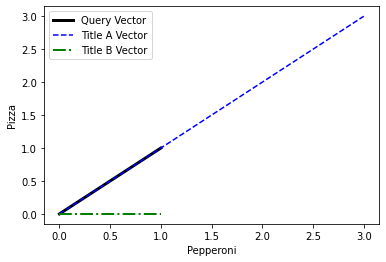

In [32]:
# Plotting TF vectors in 2D space
plt.plot([0, query_vector[0]], [0, query_vector[1]], c="k", linewidth=3, label="Query Vector")
plt.plot([0, title_a_vector[0]], [0, title_a_vector[1]], c="b", linestyle="--", label="Title A Vector")
plt.plot([0, title_b_vector[0]], [0, title_b_vector[1]], c="g", linewidth=2, linestyle="-.", label="Title B Vector")
plt.xlabel("Pepperoni")
plt.ylabel("Pizza")
plt.legend()
plt.show()

Hence, every vector has a geometric length, which is
called the magnitude. The magnitude is also called the Euclidean norm or the L2 norm.

Measuring the magnitude allows us to account for differences in geometric lengths.

Let’s output the magnitudes of our search engine vectors.

In [33]:
# Computing vector magnitude
vector_names = ["Query Vector", "Title A Vector", "Title B Vector"]
tf_search_vectors = [query_vector, title_a_vector, title_b_vector]
origin = np.array([0, 0])

for name , tf_vector in zip(vector_names, tf_search_vectors):
  # calculate the magnitude using Euclidean distance
  magnitude = euclidean(tf_vector, origin)
  # calculate the magnitude using Numpy's norm
  assert magnitude == norm(tf_vector)
  # calculate the magnitude using dot product
  assert magnitude == (tf_vector @ tf_vector) ** .5
  print(f"{name}'s magnitude is approximately {magnitude:.4f}")

magnitude_ratio = norm(title_a_vector) / norm(query_vector)
print(f"\nVector A is {magnitude_ratio:.0f}x as long as Query Vector")

Query Vector's magnitude is approximately 1.4142
Title A Vector's magnitude is approximately 4.2426
Title B Vector's magnitude is approximately 1.0000

Vector A is 3x as long as Query Vector


A vector with a
magnitude of 1 is referred to as a unit vector. Unit vectors have many useful properties,one benefit of unit vectors is that they are easy to compare:
since unit vectors share an equal magnitude, it doesn’t play a role in their similarity.

Fundamentally, the difference between unit vectors is determined solely by direction.

Dividing any
vector by its magnitude transforms that magnitude to 1. 

That division by the magnitude
is called normalization, since the magnitude is also referenced as the L2 norm.

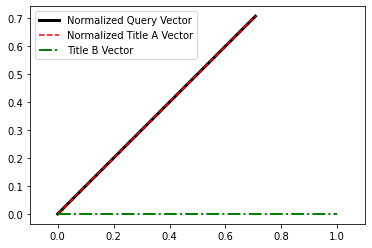

In [35]:
# Plotting normalized vectors
unit_query_vector = query_vector / norm(query_vector)
unit_title_a_vector = title_a_vector / norm(title_a_vector)
assert np.allclose(unit_query_vector, unit_title_a_vector)
# This vector is already a unit vector.There is no need to normalize
unit_title_b_vector = title_b_vector / norm(title_b_vector)

plt.plot([0, unit_query_vector[0]], [0, unit_query_vector[1]], c="k", linewidth=3, label="Normalized Query Vector")
plt.plot([0, unit_title_a_vector[0]], [0, unit_title_a_vector[1]], c="r", linestyle="--", label="Normalized Title A Vector")
plt.plot([0, unit_title_b_vector[0]], [0, unit_title_b_vector[1]], c="g", linewidth=2, linestyle="-.", label="Title B Vector")
plt.axis("equal")
plt.legend()
plt.show()

In [36]:
# Ranking titles by unit vector similarity
unit_title_vectors = [unit_title_a_vector, unit_title_b_vector]
similarities = [tanimoto_similarity(unit_query_vector, unit_title_vector) for unit_title_vector in unit_title_vectors]

for index in sorted(range(len(titles)), key=lambda i: similarities[i], reverse=True):
  title = titles[index]
  similarity = similarities[index]
  print(f"{title} has a normalized query similarity of {similarity:.4f}")

A: Pepperoni Pizza! Pepperoni Pizza! Pepperoni Pizza! has a normalized query similarity of 1.0000
B: Pepperoni has a normalized query similarity of 0.5469


In [37]:
# Computing a unit vector Tanimoto similarity
def normalized_tanimoto(u1, u2):
  dot_product = u1 @ u2
  return dot_product / (2 - dot_product)

In [38]:
for unit_title_vector in unit_title_vectors[1:]:
  similarity = normalized_tanimoto(unit_query_vector, unit_title_vector)
  assert similarity == tanimoto_similarity(unit_query_vector, unit_title_vector)

The dot product of two unit vectors is a very special value. It can easily be converted
into the angle between the vectors and also into the spatial distance between them.

Fortunately, math gives you a way out. If your vectors are normalized, their Tanimoto
similarity can be substituted with the Euclidean and cosine metrics. This is because all
three measures are very closely related to the normalized dot product.

###Relevance metrics using dot products